In [1]:
"""The point of this code block is to import libraries and load data.

The data files are four CSV files located in the Data Source subfolder
of the root drive.
"""
# Import libraries. Commented out the pip install commands since they
# only need to be run once.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %pip install seaborn
# %pip install scipy
# %pip install folium
# %pip install geopy
import folium
import seaborn as sns
from datetime import datetime


# Read CSV files into DataFrames.
#../Data Source/airbnb_vancouver_2023_listings/
abnb_q4 = pd.read_csv('listings_Dec2023.csv')
abnb_q3 = pd.read_csv('listings_Sep2023.csv')
abnb_q2 = pd.read_csv('listings_Jun2023.csv')
abnb_q1 = pd.read_csv('listings_Mar2023.csv')

# Stack the four DataFrames into one and print out columns.
abnb_orig = pd.concat(
    [abnb_q4,
     abnb_q3,
     abnb_q2,
     abnb_q1
     ],
    ignore_index=True
)


In [2]:
"""Data cleaning code."""
# Keep just the code we want.
abnb = abnb_orig[
    ['last_scraped',
     'id',
     'host_id',
     'host_since',
     'host_is_superhost',
     'host_total_listings_count',
     'neighbourhood_cleansed',
     'latitude',
     'longitude',
     'property_type',
     'room_type',
     'accommodates',
     'beds',
     'price',
     'number_of_reviews',
     'number_of_reviews_ltm',
     'review_scores_rating',
     'reviews_per_month'
     ]
]

# Rename the neighbourhood column to make it more concise.
abnb = abnb.rename(columns={"neighbourhood_cleansed": "neighbourhood"})

# Convert prices from string to float.
# Replace $ symbol with nothing.
abnb.loc[:, 'price'] = abnb.loc[:, "price"].str.replace("$", "")
# Replace commas with nothing.
abnb.loc[:, 'price'] = abnb.loc[:, "price"].str.replace(",", "")
# Change column type from string to numeric.
abnb["price"] = pd.to_numeric(abnb["price"])

# Get rid of rows that do not have price or bed data.
abnb = abnb[-pd.isna(abnb["price"])]
abnb = abnb[-pd.isna(abnb["beds"])]

# The original DataFrame had a problem with outliers.
# Remove rows with a price above $1000.00.
abnb = abnb[abnb['price'] <= 1000]

# Make a month column out of the last_scraped column.
abnb['last_scraped'] = pd.to_datetime(abnb['last_scraped'])
abnb['month'] = abnb['last_scraped'].dt.month

# Inspect values.
print(abnb['month'].value_counts())

# Make a quarter column.
month_to_quarter = {
    3: 1,
    6: 2,
    9: 3,
    12: 4
}
abnb['quarter'] = abnb['month'].map(month_to_quarter)

# Define the q4 DataFrame as anything in the 12th month.
abnb_q4 = abnb[abnb['month'] == 12]

# Show some information.
print(abnb.info())
print(abnb_q4.info())
print(abnb.head(5))




month
9     6591
6     6236
3     5873
12    5769
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 24469 entries, 0 to 25715
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   last_scraped               24469 non-null  datetime64[ns]
 1   id                         24469 non-null  int64         
 2   host_id                    24469 non-null  int64         
 3   host_since                 24469 non-null  object        
 4   host_is_superhost          23107 non-null  object        
 5   host_total_listings_count  24469 non-null  int64         
 6   neighbourhood              24469 non-null  object        
 7   latitude                   24469 non-null  float64       
 8   longitude                  24469 non-null  float64       
 9   property_type              24469 non-null  object        
 10  room_type                  24469 non-null  object        
 

In [3]:
print(abnb['quarter'].value_counts())


quarter
3    6591
2    6236
1    5873
4    5769
Name: count, dtype: int64


Index(['Downtown', 'West End', 'Kitsilano', 'Mount Pleasant',
       'Kensington-Cedar Cottage', 'Downtown Eastside', 'Riley Park',
       'Grandview-Woodland', 'Hastings-Sunrise', 'Renfrew-Collingwood',
       'Dunbar Southlands', 'Marpole', 'Fairview', 'Sunset',
       'Victoria-Fraserview'],
      dtype='object', name='neighbourhood')


<Axes: ylabel='Frequency'>

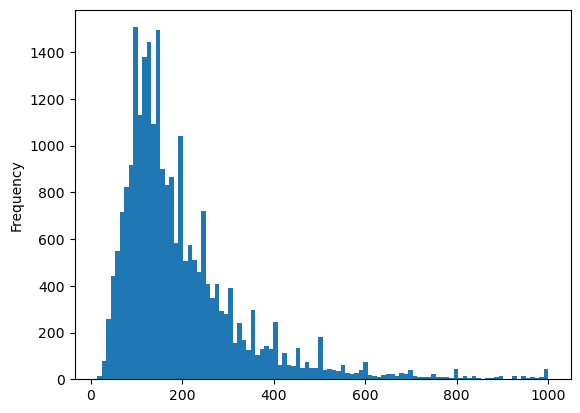

In [4]:
"""Histogram visualization of price in the 15 neighbourhoods
with the most listings.
"""

# Show the top 15 neighbourhoods with the most listings.
top_area = (
    abnb['neighbourhood']
    .value_counts()
    .sort_values(ascending=False)
    .head(15)
    .index
)
print(top_area)

# Plot the price of the top 15 neighbourhoods by number of listings.
abnb['price'].plot.hist(bins=100)


quarter
1    Axes(0.125,0.11;0.775x0.77)
2    Axes(0.125,0.11;0.775x0.77)
3    Axes(0.125,0.11;0.775x0.77)
4    Axes(0.125,0.11;0.775x0.77)
Name: price, dtype: object

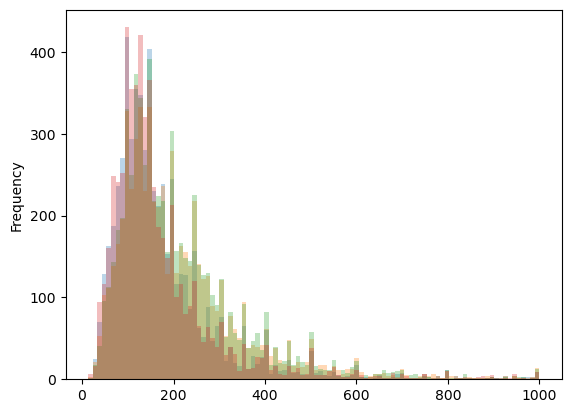

In [5]:
# Plot the price of the top 15 neighbourhoods by number of quarter.
abnb.groupby(["quarter"])["price"].plot(kind="hist", bins=100, alpha=0.3)

AttributeError: 'numpy.int64' object has no attribute 'startswith'

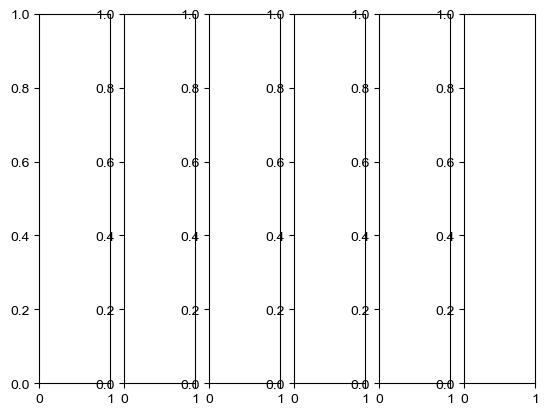

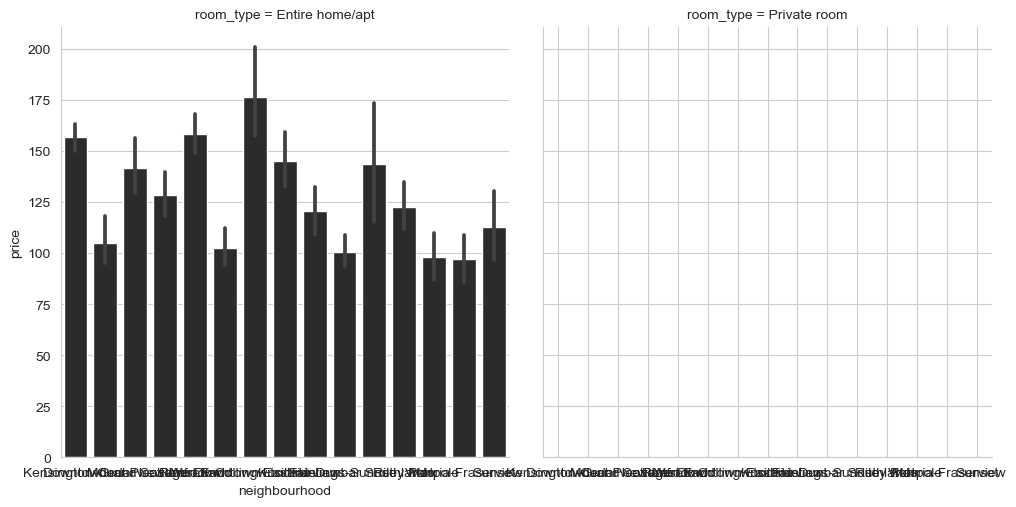

In [6]:
"""Subplot code."""

# Set subplot options.
fig, axes = plt.subplots(1, 6)
sns.set_style('whitegrid')
sns.set_palette('Greys_r')

# First subplot is a bar chart showing price by neighbourhood.
axes[0] = sns.catplot(
    x='neighbourhood',
    y='price',
    col='room_type',
    hue='accommodates',
    kind='bar',
    data=(abnb[abnb['accommodates'].isin([2])
               & abnb['room_type'].isin(['Entire home/apt', 'Private room'])
               & abnb['neighbourhood'].isin(top_area)
               & abnb['month'].isin([12])
               ]
          )
)
axes[0].set_xticklabels(rotation=90)

# Create pivot table for second axis plot.
stat_by_neigh = pd.pivot_table(abnb_q4,
                               values=['price',
                                       'review_scores_rating',
                                       'id',
                                       'number_of_reviews_ltm',
                                       'latitude',
                                       'longitude'
                                       ],
                               index=['neighbourhood'],
                               aggfunc={'price': 'median',
                                        'review_scores_rating': 'median',
                                        'id': 'count',
                                        'number_of_reviews_ltm': 'sum',
                                        'latitude': 'median',
                                        'longitude': 'median'
                                        }
                               )

# Sort pivot table by descending review scores.
stat_by_neigh = (
    stat_by_neigh.sort_values(
        by='review_scores_rating',
        ascending=False)
    .reset_index()
)

# Second subplot shows review scores by neighborhood.
axes[1] = sns.catplot(
    x='neighbourhood',
    y='review_scores_rating',
    kind='bar',
    data=stat_by_neigh
)
axes[1].set_xticklabels(rotation=90)
axes[1].set(ylim=(4.7, 5))

# Third subplot is a bar chart of most-expensive to least-expensive
# median prices by neighbourhood.
axes[2] = sns.catplot(
    x='neighbourhood',
    y='price',
    kind='bar',
    data=stat_by_neigh.sort_values(by='price', ascending=False)
)
axes[2].set_xticklabels(rotation=90)
axes[2].set(ylim=(70, None))

# Show the pivot table.
stat_by_neigh

# Fourth subplot is a box plot of price in the Fairview and Victoria-
# Fraserview neighborhoods.
axes[3] = sns.catplot(
    x='neighbourhood',
    y='price',
    kind='box',
    palette='Greys_r',
    data=(
        abnb[
            abnb['room_type'].isin(['Private room'])
            & abnb['neighbourhood'].isin(['Fairview', 'Victoria-Fraserview'])
        ]
    )
)

# Fifth subplot is a box plot of price in all neighbourhoods by quarter in Private Rooms.
axes[4] = sns.catplot(
    x='quarter',
    y='price',
    kind='box',
    palette='Greys_r',
    data=(abnb[abnb['room_type'].isin(['Private room'])])
)

# Sixth subplot is a box plot of price by quarter in entire homes.
axes[4] = sns.catplot(
    x='quarter',
    y='price',
    kind='box',
    palette='Greys_r',
    data=(abnb[abnb['room_type'].isin(['Entire home/apt'])])
)

In [8]:
"""This code block creates a map showing median price and rating among
Vancouver neighbourhoods.
"""

# Create map object.
map = folium.Map(location=[49.24445179910618, -123.11257056533111],
                 zoom_start=12,
                 tiles="cartodb positron"
                 )

stat_by_neigh_all = pd.pivot_table(abnb,
                               values=['price',
                                       'review_scores_rating',
                                       'id',
                                       'number_of_reviews_ltm',
                                       'latitude',
                                       'longitude'
                                       ],
                               index=['neighbourhood'],
                               aggfunc={'price': 'median',
                                        'review_scores_rating': 'median',
                                        'id': 'count',
                                        'number_of_reviews_ltm': 'sum',
                                        'latitude': 'median',
                                        'longitude': 'median'
                                        }
                               )

# Sort pivot table by descending review scores.
stat_by_neigh_all = (
    stat_by_neigh_all.sort_values(
        by='review_scores_rating',
        ascending=False)
    .reset_index()
)

# Add popup icons to map.
for index, row in stat_by_neigh_all.iterrows():
    folium.Marker(
        [row['latitude'],
         row['longitude']
         ],
        popup=(
                row['neighbourhood'] + "\n"
                + "Rating: " + str(row['review_scores_rating'])
                + "\n" + "Price: $" + str(row['price'])
        )
    ).add_to(map)

# Show map.
map


In [9]:
"""This code block creates a map showing median price and rating among
Vancouver neighbourhoods in Q1.
"""

# Create map object.
map = folium.Map(location=[49.24445179910618, -123.11257056533111],
                 zoom_start=12,
                 tiles="cartodb positron"
                 )

abnb_q1 = abnb[abnb['quarter'] == 1]

stat_by_neigh_q1 = pd.pivot_table(abnb_q1,
                               values=['price',
                                       'review_scores_rating',
                                       'id',
                                       'number_of_reviews_ltm',
                                       'latitude',
                                       'longitude'
                                       ],
                               index=['neighbourhood'],
                               aggfunc={'price': 'median',
                                        'review_scores_rating': 'median',
                                        'id': 'count',
                                        'number_of_reviews_ltm': 'sum',
                                        'latitude': 'median',
                                        'longitude': 'median'
                                        }
                               )

# Sort pivot table by descending review scores.
stat_by_neigh_q1 = (
    stat_by_neigh_q1.sort_values(
        by='review_scores_rating',
        ascending=False)
    .reset_index()
)

# Add popup icons to map.
for index, row in stat_by_neigh_q1.iterrows():
    folium.Marker(
        [row['latitude'],
         row['longitude']
         ],
        popup=(
                row['neighbourhood'] + "\n"
                + "Rating: " + str(row['review_scores_rating'])
                + "\n" + "Price: $" + str(row['price'])
        )
    ).add_to(map)

# Show map.
map


In [10]:
"""This code block creates a map showing median price and rating among
Vancouver neighbourhoods in Q2.
"""

# Create map object.
map = folium.Map(location=[49.24445179910618, -123.11257056533111],
                 zoom_start=12,
                 tiles="cartodb positron"
                 )

abnb_q2 = abnb[abnb['quarter'] == 2]

stat_by_neigh_q2 = pd.pivot_table(abnb_q2,
                               values=['price',
                                       'review_scores_rating',
                                       'id',
                                       'number_of_reviews_ltm',
                                       'latitude',
                                       'longitude'
                                       ],
                               index=['neighbourhood'],
                               aggfunc={'price': 'median',
                                        'review_scores_rating': 'median',
                                        'id': 'count',
                                        'number_of_reviews_ltm': 'sum',
                                        'latitude': 'median',
                                        'longitude': 'median'
                                        }
                               )

# Sort pivot table by descending review scores.
stat_by_neigh_q2 = (
    stat_by_neigh_q2.sort_values(
        by='review_scores_rating',
        ascending=False)
    .reset_index()
)

# Add popup icons to map.
for index, row in stat_by_neigh_q2.iterrows():
    folium.Marker(
        [row['latitude'],
         row['longitude']
         ],
        popup=(
                row['neighbourhood'] + "\n"
                + "Rating: " + str(row['review_scores_rating'])
                + "\n" + "Price: $" + str(row['price'])
        )
    ).add_to(map)

# Show map.
map


In [ ]:
"""This code block creates a map showing median price and rating among
Vancouver neighbourhoods in Q3.
"""

# Create map object.
map = folium.Map(location=[49.24445179910618, -123.11257056533111],
                 zoom_start=12,
                 tiles="cartodb positron"
                 )

abnb_q3 = abnb[abnb['quarter'] == 3]

stat_by_neigh_q3 = pd.pivot_table(abnb_q3,
                               values=['price',
                                       'review_scores_rating',
                                       'id',
                                       'number_of_reviews_ltm',
                                       'latitude',
                                       'longitude'
                                       ],
                               index=['neighbourhood'],
                               aggfunc={'price': 'median',
                                        'review_scores_rating': 'median',
                                        'id': 'count',
                                        'number_of_reviews_ltm': 'sum',
                                        'latitude': 'median',
                                        'longitude': 'median'
                                        }
                               )

# Sort pivot table by descending review scores.
stat_by_neigh_q3 = (
    stat_by_neigh_q3.sort_values(
        by='review_scores_rating',
        ascending=False)
    .reset_index()
)

# Add popup icons to map.
for index, row in stat_by_neigh_q3.iterrows():
    folium.Marker(
        [row['latitude'],
         row['longitude']
         ],
        popup=(
                row['neighbourhood'] + "\n"
                + "Rating: " + str(row['review_scores_rating'])
                + "\n" + "Price: $" + str(row['price'])
        )
    ).add_to(map)

# Show map.
map


In [11]:
"""This code block creates a map showing median price and rating among
Vancouver neighbourhoods in Q4 (using the already-created stat_by_neigh pivot
table since that was Q4).
"""

# Create map object.
map = folium.Map(location=[49.24445179910618, -123.11257056533111],
                 zoom_start=12,
                 tiles="cartodb positron"
                 )

# Add popup icons to map.
for index, row in stat_by_neigh.iterrows():
    folium.Marker(
        [row['latitude'],
         row['longitude']
         ],
        popup=(
                row['neighbourhood'] + "\n"
                + "Rating: " + str(row['review_scores_rating'])
                + "\n" + "Price: $" + str(row['price'])
        )
    ).add_to(map)

# Show map.
map


NameError: name 'stat_by_neigh' is not defined

In [ ]:
#drop any rows where there are no listed prices or ratings
abnb = abnb.rename(columns={"review_scores_rating":"rating"})
abnb = abnb.dropna()

display(abnb)

In [ ]:
#boxplot by neighborhood for all listings with rating
abnb.boxplot(by ='neighbourhood', column =['rating'], grid = False,rot=90)

In [ ]:
#to remove outliers, find interquartile range (IQR) for ratings
Q1 = abnb['rating'].quantile(0.25)
Q3 = abnb['rating'].quantile(0.75)
IQR = Q3 - Q1

# Filtering Values in interquartile range (between Q1-1.5IQR and Q3+1.5IQR)
rating_iqr = abnb.query('(@Q1 - 1.5 * @IQR) <= rating <= (@Q3 + 1.5 * @IQR)')


display(rating_iqr)

In [ ]:
#boxplot by neighborhood for interquartile range
rating_iqr.boxplot(by ='neighbourhood', column =['rating'], grid = False,rot=90)

In [ ]:
#Using IQR range of data, create scatterplots for quick visualization of any correlation of rating vs price 

#Removing columns not needed for scatterplot
rating_iqr_scat = rating_iqr[['neighbourhood', 'rating', 'price']]

#scatterplot rating vs price
sns.jointplot(data=rating_iqr_scat, x="rating", y="price", hue="neighbourhood")
plt.legend(bbox_to_anchor=(1, 1.2), loc='upper left', borderaxespad=6.5)


#scatterplot matrix rating vs price
sns.pairplot(rating_iqr_scat, hue='neighbourhood')



#correlation between price and rating
print(rating_iqr_scat[['rating', 'price']].corr())

In [ ]:
#calculating median price and median rating, grouped by neighbourhood

rating_iqr_neigh = pd.pivot_table(rating_iqr,values=['price','rating','id','number_of_reviews_ltm','latitude','longitude'],\
                               index=['neighbourhood'],aggfunc={'price':'median','rating':'median',\
                                                                'id':'count','number_of_reviews_ltm':'sum',
                                                                'latitude':'median','longitude':'median'})

rating_iqr_neigh = rating_iqr_neigh.sort_values(by='rating',ascending=False).reset_index()
rating_iqr_neigh = rating_iqr_neigh.sort_values(by='price', ascending=False)

rating_iqr_neigh = rating_iqr_neigh.rename(columns={"price":"median_price", "rating":"median_rating"})

display(rating_iqr_neigh)


In [ ]:
#bar chart mean rating by neighborhood

axes[1]=sns.catplot(x='neighbourhood',y='median_rating',kind='bar',data=rating_iqr_neigh).set(title='Neighbourhood Median Ratings')
axes[1].set_axis_labels("Neighbourhood", "Median Rating")
axes[1].set_xticklabels(rotation=90)
axes[1].set(ylim=(4.7,5))

In [ ]:
#scatterplot of median rating vs median price using Seaborn

ax = sns.lmplot(x='median_rating', # Horizontal axis
                y='median_price', # Vertical axis
                data=rating_iqr_neigh, # Data source
                fit_reg=False, # Don't fix a regression line
                aspect=2) # size and dimension

plt.title('Median Rating vs Median Price by Neighborhood')
# Set x-axis label
plt.xlabel('Median Rating')
# Set y-axis label
plt.ylabel('Median Price')


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.001, point['y'], str(point['val']))

label_point(rating_iqr_neigh.median_rating, rating_iqr_neigh.median_price, rating_iqr_neigh.neighbourhood, plt.gca()) 
    

In [ ]:
#histogram of number of reviews


rating_iqr['number_of_reviews'].hist(grid=False, bins=range(0,500,50))
plt.xlabel('Number of reviews for a listing')
plt.ylabel('Number of listings')
plt.title('Summary of listings based on total reviews')

In [ ]:
#histogram of reviews of listings with 50 reviews or less

rating_iqr['number_of_reviews'].hist(grid=False, bins=range(0,50,1))
plt.xlabel('Number of reviews for a given listing')
plt.ylabel('Number of listings')
plt.title('Number of listings with 50 reviews or less')

In [12]:
"This Block of Code adds the Vancouver Parks/Green Spaces Dataset to be used for analysis"

parks_df = pd.read_csv('parks.csv',sep=';')

parks_df[['Latitude', 'Longitude']] = parks_df['GoogleMapDest'].str.split(',', expand=True)

parks_df

,ParkID,Name,Official,Advisories,SpecialFeatures,Facilities,Washrooms,StreetNumber,StreetName,EWStreet,NSStreet,NeighbourhoodName,NeighbourhoodURL,Hectare,GoogleMapDest,Latitude,Longitude
0,1,Arbutus Village Park,1,N,N,Y,N,4202,Valley Drive,King Edward Avenue,Valley Drive,Arbutus-Ridge,https://vancouver.ca/news-calendar/arbutus-rid...,1.41,"49.249783, -123.15525",49.249783,-123.15525
1,4,Park Site on Puget Drive,0,N,N,N,N,4309,Puget Drive,Puget Drive,MacDonald Street,Arbutus-Ridge,https://vancouver.ca/news-calendar/arbutus-rid...,0.09,"49.247723, -123.168194",49.247723,-123.168194
2,10,Andy Livingstone Park,1,N,N,Y,Y,89,Expo Boulevard,Expo Boulevard,Carrall Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,4.21,"49.278923, -123.1055",49.278923,-123.1055
3,14,Coopers' Park,1,N,Y,Y,N,1020,Marinaside Crescent,Nelson Street,Marinaside Crescent,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,1.71,"49.273253, -123.1139",49.273253,-123.1139
4,18,Devonian Harbour Park,1,N,Y,Y,N,1929,W Georgia Street,W Georgia Street,Denman Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,4.42,"49.294353, -123.134654",49.294353,-123.134654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,231,Camosun,0,N,N,N,N,4102,W 16th Avenue,W 16th Avenue,Discovery Street,Dunbar-Southlands,https://vancouver.ca/news-calendar/dunbar-sout...,0.00,"49.257423, -123.201329",49.257423,-123.201329
212,233,Arbutus Greenway Park,1,N,N,N,N,2205,W11th Avenue,W 11th Avenue,Arbutus Street,Kitsilano,https://vancouver.ca/news-calendar/kitsilano.aspx,1.08,"49.262283, -123.154927",49.262283,-123.154927
213,237,Yaletown Park,1,N,N,N,N,901,Mainland Street,Mainland Street,Nelson Street,Downtown,https://vancouver.ca/news-calendar/downtown.aspx,0.17,"49.277042, -123.118921",49.277042,-123.118921
214,244,Fraser River Trail,1,N,N,N,N,9149,Hudson Street,SW Marine Drive,Hudson Street,Marpole,https://vancouver.ca/news-calendar/marpole.aspx,0.35,"49.200357, -123.135862",49.200357,-123.135862


In [13]:
"This is to verify if there's any differences in the neighbourhood attribute"
"THERE IS, We will need to create a map to replace the values in the park dataset to match our abnb dataset"

print("Air BNB Neighbourhoods: ", abnb['neighbourhood'].unique(),'\n')
print("Parks Neighbourhoods: ", parks_df['NeighbourhoodName'].unique(),'\n')

Air BNB Neighbourhoods:  ['Riley Park' 'Downtown' 'Kensington-Cedar Cottage' 'Hastings-Sunrise'
 'Grandview-Woodland' 'Mount Pleasant' 'West End' 'Renfrew-Collingwood'
 'Kitsilano' 'Downtown Eastside' 'Arbutus Ridge' 'Killarney'
 'South Cambie' 'Fairview' 'Dunbar Southlands' 'Shaughnessy'
 'West Point Grey' 'Kerrisdale' 'Sunset' 'Victoria-Fraserview' 'Marpole'
 'Strathcona' 'Oakridge'] 

Parks Neighbourhoods:  ['Arbutus-Ridge' 'Downtown' 'Dunbar-Southlands' 'Fairview'
 'Grandview-Woodland' 'Hastings-Sunrise' 'Kensington-Cedar Cottage'
 'Kerrisdale' 'Killarney' 'Kitsilano' 'Marpole' 'Mount Pleasant'
 'Renfrew-Collingwood' 'Riley Park' 'Shaughnessy' 'Strathcona' 'Sunset'
 'Victoria-Fraserview' 'West End' 'West Point Grey' 'South Cambie'
 'Oakridge'] 



In [14]:
"This will create the mapping for the two different values, This dataset is also missing eastside downtown and is assumed into a downtown neighbour instead" 

neighbourhood_mapping = {
    'Arbutus-Ridge': 'Arbutus Ridge',
    'Dunbar-Southlands': 'Dunbar Southlands',
    
}

parks_df['NeighbourhoodName'] = parks_df['NeighbourhoodName'].replace(neighbourhood_mapping)
parks_df['NeighbourhoodName']

0          Arbutus Ridge
1          Arbutus Ridge
2               Downtown
3               Downtown
4               Downtown
             ...        
211    Dunbar Southlands
212            Kitsilano
213             Downtown
214              Marpole
215           Strathcona
Name: NeighbourhoodName, Length: 216, dtype: object

In [15]:
"This requires GEOPY addin"
"If you haven't already kindly uncomment and run the following line"

# %pip install geopy

"WILL TAKE A LONG TIME TO RUN 1-2 MINS Depnding on your CPU as it will use great circle to"
"calculate the distance of each individual row of our dataset"

#Calculating the distance to the nearest park using great_circle from geopy

from geopy.distance import great_circle

# Define the function to find the nearest park's distance
def find_nearest_park_distance(airbnb_location, parks_df):
    min_distance = float('inf')  # Initialize with a very large number

    # Iterate over each park in the DataFrame
    for _, park in parks_df.iterrows():
        park_location = (park['Latitude'], park['Longitude'])
        distance = great_circle(airbnb_location, park_location).meters  # Calculate distance in meters

        # Update min_distance if the current park is closer
        if distance < min_distance:
            min_distance = distance

    return min_distance  # Return the minimum distance

# Apply the function to each Airbnb listing to calculate the closest park distance
abnb['distance_to_closest_park'] = abnb.apply(
    lambda x: find_nearest_park_distance((x['latitude'], x['longitude']), parks_df),
    axis=1
)

In [16]:
abnb = abnb.round({'distance_to_closest_park': 1})
abnb

,last_scraped,id,host_id,host_since,host_is_superhost,host_total_listings_count,neighbourhood,latitude,longitude,property_type,...,accommodates,beds,price,number_of_reviews,number_of_reviews_ltm,review_scores_rating,reviews_per_month,month,quarter,distance_to_closest_park
0,2023-12-14,13188,51466,2009-11-04,f,3,Riley Park,49.247730,-123.105090,Entire rental unit,...,4,2.0,150.0,283,30,4.84,1.68,12,4,411.5
1,2023-12-14,13221,51634,2009-11-05,f,4,Riley Park,49.254890,-123.097080,Entire rental unit,...,4,2.0,120.0,15,0,4.73,0.15,12,4,268.3
2,2023-12-14,13358,52116,2009-11-07,f,1,Downtown,49.281174,-123.125931,Entire condo,...,2,1.0,165.0,493,55,4.68,3.00,12,4,322.8
3,2023-12-13,13490,52467,2009-11-08,t,4,Kensington-Cedar Cottage,49.256220,-123.066070,Entire rental unit,...,2,1.0,150.0,101,5,4.93,0.66,12,4,281.6
4,2023-12-13,14267,56030,2009-11-20,f,1,Kensington-Cedar Cottage,49.249220,-123.081390,Entire home,...,4,2.0,150.0,33,0,4.76,0.21,12,4,111.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25711,2023-03-14,845284101352923786,504936838,2023-03-11,f,1,Riley Park,49.237248,-123.104728,Entire guest suite,...,4,2.0,104.0,0,0,NaN,NaN,3,1,527.7
25712,2023-03-14,845854561820158781,49461922,2015-11-20,f,3,Mount Pleasant,49.269547,-123.110062,Entire rental unit,...,2,1.0,120.0,0,0,NaN,NaN,3,1,150.9
25713,2023-03-14,845891831251005257,97054642,2016-09-28,f,2,Victoria-Fraserview,49.216332,-123.055613,Entire home,...,8,4.0,339.0,0,0,NaN,NaN,3,1,201.7
25714,2023-03-14,845936827653470100,3664868,2012-09-24,f,1,Kitsilano,49.259028,-123.156587,Private room in home,...,1,1.0,105.0,0,0,NaN,NaN,3,1,315.9


In [17]:
abnb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24469 entries, 0 to 25715
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   last_scraped               24469 non-null  datetime64[ns]
 1   id                         24469 non-null  int64         
 2   host_id                    24469 non-null  int64         
 3   host_since                 24469 non-null  object        
 4   host_is_superhost          23107 non-null  object        
 5   host_total_listings_count  24469 non-null  int64         
 6   neighbourhood              24469 non-null  object        
 7   latitude                   24469 non-null  float64       
 8   longitude                  24469 non-null  float64       
 9   property_type              24469 non-null  object        
 10  room_type                  24469 non-null  object        
 11  accommodates               24469 non-null  int64         
 12  beds     

c:\Users\jverc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


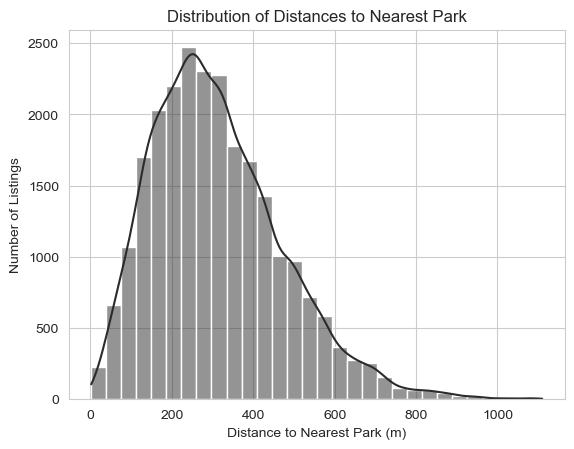

In [18]:
sns.histplot(abnb['distance_to_closest_park'], bins=30, kde=True)
plt.title('Distribution of Distances to Nearest Park')
plt.xlabel('Distance to Nearest Park (m)')
plt.ylabel('Number of Listings')
plt.show()

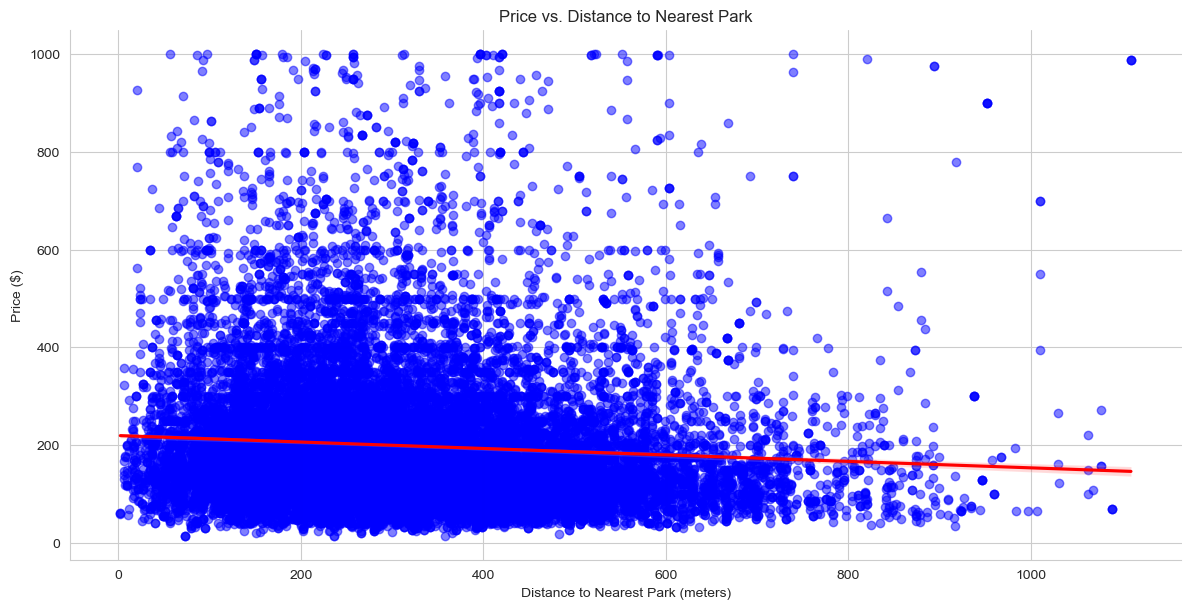

In [19]:
sns.lmplot(x='distance_to_closest_park', y='price', data=abnb,
           aspect=2, height=6, line_kws={'color': 'red'}, scatter_kws={'alpha':0.5, 'color': 'blue'})

plt.title('Price vs. Distance to Nearest Park')
plt.xlabel('Distance to Nearest Park (meters)')
plt.ylabel('Price ($)')

plt.show()

In [20]:
#Adding distance to closest park to our nieghborhood pivot to find the average distance in each neighbourhood to greenspace

stat_by_neigh_dist = pd.pivot_table(abnb,
                               values=['price',
                                       'review_scores_rating',
                                       'id',
                                       'number_of_reviews_ltm',
                                       'latitude',
                                       'longitude','distance_to_closest_park'
                                       ],
                               index=['neighbourhood'],
                               aggfunc={'price': 'median',
                                        'review_scores_rating': 'median',
                                        'id': 'count',
                                        'number_of_reviews_ltm': 'sum',
                                        'latitude': 'median',
                                        'longitude': 'median', 'distance_to_closest_park': 'mean'
                                        }
                               )

# Sort pivot table by descending distance to closest park.
stat_by_neigh_dist = (
    stat_by_neigh_dist.sort_values(
        by='distance_to_closest_park',
        ascending=False)
    .reset_index()
)

stat_by_neigh_dist

,neighbourhood,distance_to_closest_park,id,latitude,longitude,number_of_reviews_ltm,price,review_scores_rating
0,West Point Grey,483.553659,410,49.262738,-123.203940,4665,168.0,4.87
1,Dunbar Southlands,481.574282,766,49.244788,-123.184290,8104,145.0,4.86
2,Killarney,474.433333,333,49.225689,-123.035865,4734,128.0,4.82
3,Kerrisdale,474.359882,339,49.226650,-123.154324,3213,109.0,4.86
4,Sunset,428.406503,569,49.223111,-123.094410,7419,131.0,4.85
5,Shaughnessy,426.038047,297,49.245120,-123.137850,2924,150.0,4.75
6,Oakridge,416.995466,397,49.226350,-123.122280,3805,100.0,4.83
7,Victoria-Fraserview,404.967568,518,49.220119,-123.066560,6774,123.0,4.82
8,Hastings-Sunrise,387.859590,975,49.278040,-123.042930,16149,120.0,4.89
9,Riley Park,378.791018,1169,49.248240,-123.101450,17654,149.0,4.90


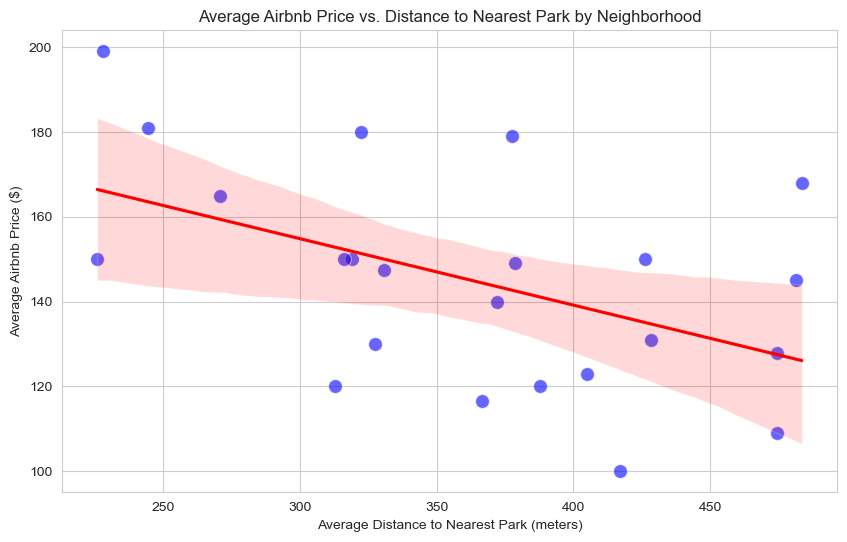

In [21]:
stat_by_neigh_dist['distance_to_closest_park'] = pd.to_numeric(stat_by_neigh_dist['distance_to_closest_park'], errors='coerce')
stat_by_neigh_dist['price'] = pd.to_numeric(stat_by_neigh_dist['price'], errors='coerce')

# Create the scatter plot 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_to_closest_park', y='price', data=stat_by_neigh_dist, s=100, color="blue", alpha=0.6)

#Adding a regression Line to visualize the correlation
sns.regplot(x='distance_to_closest_park', y='price', data=stat_by_neigh_dist, scatter=False, color="red")

plt.title('Average Airbnb Price vs. Distance to Nearest Park by Neighborhood')
plt.xlabel('Average Distance to Nearest Park (meters)')
plt.ylabel('Average Airbnb Price ($)')
plt.grid(True)
plt.show()

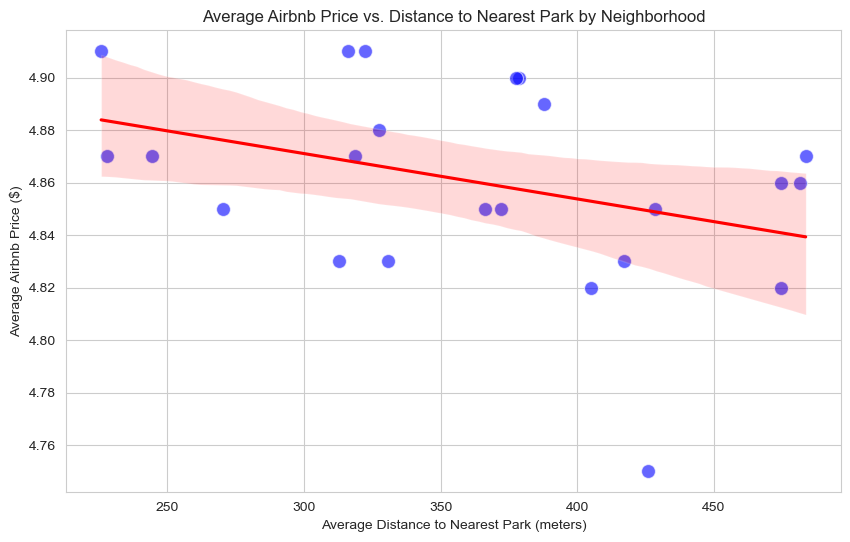

In [23]:
stat_by_neigh_dist['distance_to_closest_park'] = pd.to_numeric(stat_by_neigh_dist['distance_to_closest_park'], errors='coerce')
stat_by_neigh_dist['review_scores_rating'] = pd.to_numeric(stat_by_neigh_dist['review_scores_rating'], errors='coerce')

# Create the scatter plot 
plt.figure(figsize=(10, 6))
sns.scatterplot(x='distance_to_closest_park', y='review_scores_rating', data=stat_by_neigh_dist, s=100, color="blue", alpha=0.6)

#Adding a regression Line to visualize the correlation
sns.regplot(x='distance_to_closest_park', y='review_scores_rating', data=stat_by_neigh_dist, scatter=False, color="red")

plt.title('Average Airbnb Price vs. Distance to Nearest Park by Neighborhood')
plt.xlabel('Average Distance to Nearest Park (meters)')
plt.ylabel('Average Airbnb Price ($)')
plt.grid(True)
plt.show()

In [27]:
corr_price= stat_by_neigh_dist['distance_to_closest_park'].corr(stat_by_neigh_dist['price'])
corr_rating= stat_by_neigh_dist['distance_to_closest_park'].corr(stat_by_neigh_dist['review_scores_rating'])
print(corr_price)
print(corr_rating)

-0.4866759593786387
-0.3657685751060855


In [24]:
"""This code block creates a map showing median price rating and distance to parks among
Vancouver neighbourhoods.
"""

# Create map object.
map = folium.Map(location=[49.24445179910618, -123.11257056533111],
                 zoom_start=12,
                 tiles="cartodb positron"
                 )

# Add popup icons to map.
for index, row in stat_by_neigh_dist.iterrows():
    folium.Marker(
        [row['latitude'],
         row['longitude']
         ],
        popup=(
                row['neighbourhood'] + "\n"
                + "Rating: " + str(row['review_scores_rating'])
                + "\n" + "Price: $" + str(row['price']) + '\n' +"Park Distance :" + str(row['distance_to_closest_park'])
        )
    ).add_to(map)

# Show map.
map